PWV -> nscale: 1.42
zenith -> airmass: 1.56


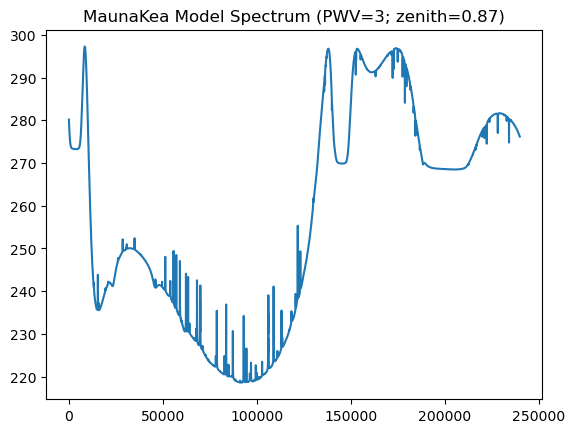

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

pwv = 3
zenith = np.radians(50)

my_ozone = Ozone()
spectrum = my_ozone(pwv, zenith)

plt.title(f"MaunaKea Model Spectrum (PWV={pwv}; zenith={zenith:.2f})")
plt.plot(spectrum[0,0])